### Imports

In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

### Read data

In [95]:
# Relative path to the results folder
results_dir = '../results/'

# List all CSV files in the results directory
csv_files = [f for f in os.listdir(results_dir) if f.startswith('benchmark_results') and f.endswith('.csv')]

benchmark_data = {}

for csv_file in csv_files:
    # Extract matrix size from filename
    size = csv_file.split('_')[-1].split('.')[0]
    benchmark_data[size] = pd.read_csv(os.path.join(results_dir, csv_file))

### Times

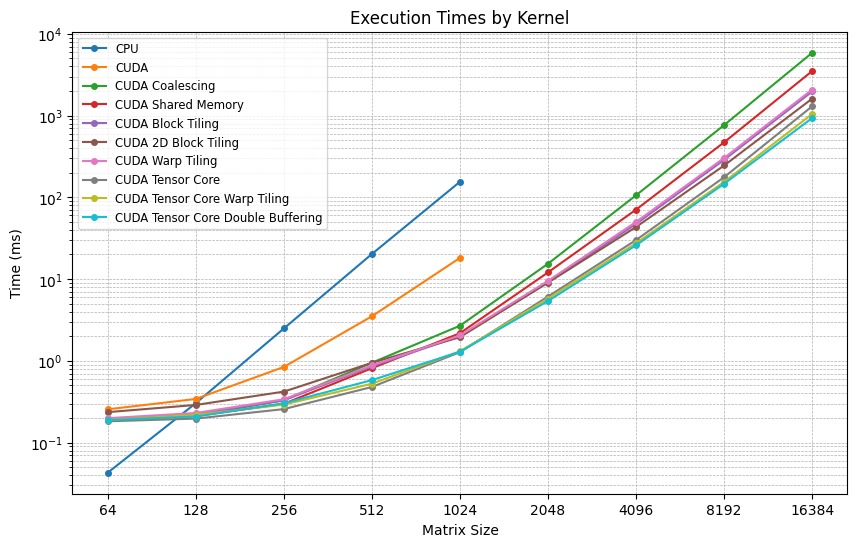

In [96]:
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()

# Get sorted sizes
sizes = sorted(benchmark_data.keys(), key=int)

# Times Plot
plt.figure(figsize=(10, 6))
for kernel in kernels:
    times = []
    for size in sizes:
        df = benchmark_data[str(size)]
        time_val = df[df['Kernel'] == kernel]['Avg_Time(s)'].values[0] * 1000 if len(df[df['Kernel'] == kernel]) > 0 else None
        times.append(time_val)
    # Filter out None for plotting
    valid_sizes = [s for s, t in zip(sizes, times) if t is not None]
    valid_times = [t for t in times if t is not None]
    plt.plot(valid_sizes, valid_times, label=kernel.replace('GEMM ', ''), marker='o', markersize=4)

plt.xlabel('Matrix Size')
plt.ylabel('Time (ms)')
plt.title('Execution Times by Kernel')
plt.legend(fontsize='small')
plt.yscale('log', base=10)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### Speed-up

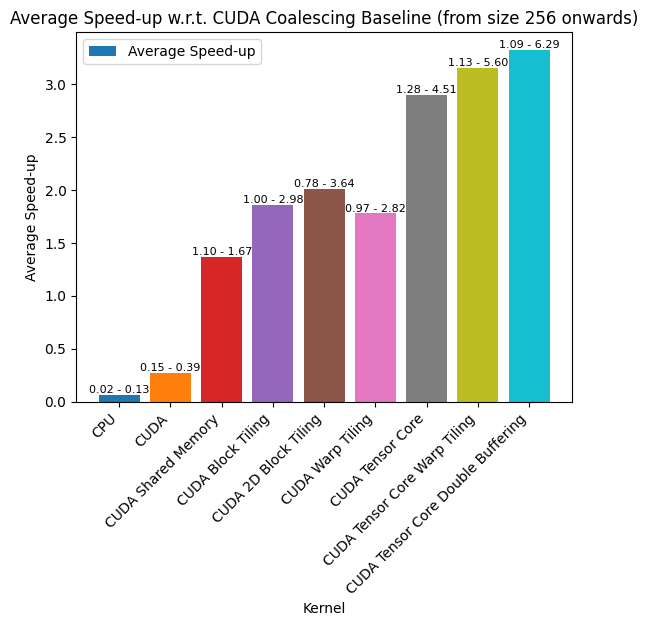

In [97]:
# Get kernels in the order they appear in the first CSV, excluding CUDA Coalescing
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()
kernels = [k for k in kernels if k != 'GEMM CUDA Coalescing']

# Get sizes from 256 onwards
sizes = sorted([int(s) for s in benchmark_data.keys() if int(s) >= 256])

# Prepare data for bar chart
avgs = []
mins = []
maxs = []
for kernel in kernels:
    speed_ups = []
    for size in sizes:
        df = benchmark_data[str(size)]
        cuda_row = df[df['Kernel'] == 'GEMM CUDA Coalescing']
        kernel_row = df[df['Kernel'] == kernel]
        if len(cuda_row) > 0 and len(kernel_row) > 0:
            cuda_time = cuda_row['Avg_Time(s)'].values[0]
            kernel_time = kernel_row['Avg_Time(s)'].values[0]
            speed_up = cuda_time / kernel_time
            speed_ups.append(speed_up)
    if speed_ups:  # Only compute if data exists
        avgs.append(np.mean(speed_ups))
        mins.append(np.min(speed_ups))
        maxs.append(np.max(speed_ups))
    else:
        avgs.append(0)  # Placeholder
        mins.append(0)
        maxs.append(0)

# Get the default color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot bars for average speed-up with matching colors
x = np.arange(len(kernels))
bars = plt.bar(x, avgs, label='Average Speed-up', color=[colors[i if i < 2 else i+1] for i in range(len(kernels))])

# Add min and max on top of each bar (only if data exists)
for i, bar in enumerate(bars):
    if avgs[i] > 0:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{mins[i]:.2f} - {maxs[i]:.2f}', ha='center', va='bottom', fontsize=8)

plt.xticks(x, [k.replace('GEMM ', '') for k in kernels], rotation=45, ha='right')
plt.xlabel('Kernel')
plt.ylabel('Average Speed-up')
plt.title('Average Speed-up w.r.t. CUDA Coalescing Baseline (from size 256 onwards)')
plt.legend()
plt.show()

### FLOPS

In [98]:
PEAK_A30 = 10_300 # GFLOPS for FP32
PEAK_A30_TENSOR = 165_000 # GFLOPS for FP16 with Tensor Cores

def create_table(size):
    if size not in benchmark_data:
        return None
    df = benchmark_data[size]
    table_data = []
    for _, row in df.iterrows():
        kernel = row['Kernel']
        time = row['Avg_Time(s)']
        flops = row['GFLOPS'] if 'GFLOPS' in df.columns and not pd.isna(row['GFLOPS']) else 0  # Use GFLOPS or 0
        if 'Tensor Core' in kernel:
            peak = PEAK_A30_TENSOR
        else:
            peak = PEAK_A30
        peak_percent = (flops / peak) * 100 if peak > 0 else 0
        table_data.append({
            'Kernel': kernel.replace('GEMM ', ''),
            'Time (s)': time,
            'GFLOPS': flops,
            'Peak %': peak_percent
        })
    return pd.DataFrame(table_data)

# Find last size with GEMM naive
last_size_naive = None
for size in sorted(benchmark_data.keys(), key=int, reverse=True):
    df = benchmark_data[size]
    if len(df[df['Kernel'] == 'GEMM CUDA']) > 0:
        last_size_naive = size
        break

# Last size in total
last_size_total = sorted(benchmark_data.keys(), key=int)[-1]

# Plot for last size with GEMM naive
if last_size_naive:
    table_naive = create_table(last_size_naive)
    if table_naive is not None:
        print(f"Table for last size with GEMM naive ({last_size_naive}):")
        display(table_naive)

# Plot for last size in total
table_total = create_table(last_size_total)
if table_total is not None:
    print(f"Table for last size ({last_size_total}):")
    display(table_total)

Table for last size with GEMM naive (1024):


,Kernel,Time (s),GFLOPS,Peak %
0,CPU,0.155215,13.8356,0.134326
1,CUDA,0.018186,118.0850,1.146456
2,CUDA Coalescing,0.002689,798.4740,7.752175
3,CUDA Shared Memory,0.002179,985.5500,9.568447
4,CUDA Block Tiling,0.002008,1069.2200,10.380777
5,CUDA 2D Block Tiling,0.001949,1101.9000,10.698058
6,CUDA Warp Tiling,0.002044,1050.7700,10.201650
7,CUDA Tensor Core,0.001279,1679.4800,1.017867
8,CUDA Tensor Core Warp Tiling,0.001309,1640.7900,0.994418
9,CUDA Tensor Core Double Buffering,0.001292,1662.2800,1.007442


Table for last size (16384):


,Kernel,Time (s),GFLOPS,Peak %
0,CUDA Coalescing,5.877640,1496.53,14.529417
1,CUDA Shared Memory,3.510850,2505.40,24.324272
2,CUDA Block Tiling,1.974450,4454.96,43.252039
3,CUDA 2D Block Tiling,1.615650,5444.29,52.857184
4,CUDA Warp Tiling,2.085740,4217.24,40.944078
5,CUDA Tensor Core,1.301980,6755.92,4.094497
6,CUDA Tensor Core Warp Tiling,1.049370,8382.29,5.080176
7,CUDA Tensor Core Double Buffering,0.934368,9413.95,5.705424


### Correctness

In [99]:
# Get kernels in the order they appear in the first CSV
first_size = sorted(benchmark_data.keys(), key=int)[0]
kernels = benchmark_data[first_size]['Kernel'].tolist()

# Get sorted sizes
sizes = sorted(benchmark_data.keys(), key=int)

# Prepare data for correctness table
correctness_data = {}
for kernel in kernels:
    errors = []
    for size in sizes:
        df = benchmark_data[size]
        error_val = df[df['Kernel'] == kernel]['Avg_Error(%)'].values[0] if len(df[df['Kernel'] == kernel]) > 0 else None
        if error_val is not None:
            errors.append(error_val)
    # Calculate average error across sizes
    avg_error = sum(errors) / len(errors) if errors else None
    correctness_data[kernel.replace('GEMM ', '')] = avg_error

correctness_df = pd.DataFrame(list(correctness_data.items()), columns=['Kernel', 'Avg_Error(%)'])

# Display the table
correctness_df

,Kernel,Avg_Error(%)
0,CPU,0.000000
1,CUDA,0.000003
2,CUDA Coalescing,0.000002
3,CUDA Shared Memory,0.000002
4,CUDA Block Tiling,0.000002
5,CUDA 2D Block Tiling,0.080056
6,CUDA Warp Tiling,0.000002
7,CUDA Tensor Core,0.001356
8,CUDA Tensor Core Warp Tiling,0.001356
9,CUDA Tensor Core Double Buffering,0.001356
